<a href="https://colab.research.google.com/github/imZiho/Deep-Learning_Seminar/blob/main/naver_movie_review_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. 네이버 영화 리뷰 데이터에 대한 이해와 전처리**

**자연어 처리란?**
NLP (Natural Language Processing, 자연어처리)는 텍스트에서 의미있는 정보를 분석, 추출, 이해하는 일련의 기술집합입니다.

**데이터 전처리?**


 기존의 데이터를 머신러닝 알고리즘에 알맞은 데이터로 바꾸는 과정입니다.

 이 전처리 과정은 모델이 생 된 이후에도 예측하고자 하는 새로운 데이터에도 적용하는 과정입니다. 또한, 전처리 과정을 통해서 더욱더 모델 학습의 성능을 높일 수 있습니다.

In [1]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [2]:
! pip install konlpy
!sudo pip3 install keras

In [3]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2023-08-09 06:09:45--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2023-08-09 06:09:46--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf4f4e71aebb9db7c6678af73f7.dl.dropboxusercontent.com/cd/0/get/CBfgYBJFsSWnBZig3GK3-3NHz6_N2mxK_StVQTHfEA0DksmyviWMoiAe9bZfKNzU3PYIJ94xyKxZh7NolBi3GEglkrxLOoYmrNMEVSFeFHQmT0PQmlwdnoSIsz4cWVjoi0o80vT7Xom7Ltk2cyPjnWhW/file?dl=1# [following]
--2023-08-09 06:09:47--  https://ucf4f4e71aebb9db7c6678af73f7.dl.dropboxusercontent.com/cd/0/get/CBfgYBJFsSWnBZig3GK3-3NHz6_N2mxK_StVQTHfEA0DksmyviWMo

In [4]:
import pickle                         # 텍스트 이외의 자료형을 파일로 저장하기 위하여 pickle이라는 모듈을 제공.
import pandas as pd                   # 밑에 데이터처리와 분석을 위해 pandas를 임포트 해오고
import numpy as np                    # pandas는 보통 numpy와 함께 import
import matplotlib.pyplot as plt
import re                             # 파이썬은 정규표현을 지원하는 re패키지 제공
import urllib.request                 # URL을 열기 위한 확장 가능한 라이브러리
from konlpy.tag import Okt            # 코엔엘파이는 여러개의 클래스를 가지고있고 토큰화를 위해 임포트 해오는 정도로 이해
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer    #Tokenizer는 문장으로부터 단어를 토큰화하고 숫자에 대응시키는 딕셔너리를 사용할 수 있도록 합니다.
from tensorflow.keras.preprocessing.sequence import pad_sequences

파이썬(Python)에서 반복 루프를 돌다 보면 진행이 얼마나 되었는
지 Progress Bar를 통해 알 수 있음.

이처럼 반복문에서 진행률을 Progress Bar로 표현해주고 남은 시간 정보까지 알려주는 것이 바로tqdm이다.

TensorFlow를 이용해서 자연어를 처리하는 방법으로  tensorflow.keras.preprocessing.text 모듈의 Tokenizer 클래스를 사용해서 텍스트를 단어               

 기반으로 토큰화함으로써 Neural Network에 사용하기 적합한 형태로 변환하는 방법

# **1)데이터 로드하기**

위 링크로부터 훈련 데이터에 해당하는 ratings_train.txt와 테스트 데이터에 해당하는 ratings_test.txt를 다운로드합니다

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7b311f934040>)

pandas를 이용하여 훈련 데이터는 train_data에 테스트 데이터는 test_data에 저장합니다.


**pandas**

**데이터 처리와 분석을 위한 라이브러리**

**행과 열로 이루어진 데이터 객체를 만들어 다룰 수 있음**

**대용량의 데이터들을 처리하는데 매우 편리**

In [6]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

**훈련데이터(train_data)에 존재하는 영화 리뷰의 개수를 확인한다.**

In [7]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


출력결과를 확인해보면 train_data에는 총 15만개의 리뷰가 존재함.

상위 5개의 샘플을 출력해보면 아래와 같은 결과 확인 가능.

In [8]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


해당 데이터는 id, document, label 총 3개의 열로 구성되어져 있다.

id는 감성 분류를 수행하는데 도움이 되지 않으므로 앞으로 무시한다.

(이 모델은 리뷰 내용을 담고있는 document와 해당 리뷰가 긍정(1), 부정(0)인지를 나타내는 label )두 개의 열을 학습하는 모델이 되어야 합니다.

**이제는 테스트데이터(test_data)의 리뷰 개수와 상위 5개의 샘플을 확인해본다.**

In [9]:
print('테스트용 리뷰 개수 :',len(test_data)) # test_data는 총 5만개의 영화 리뷰가 존재함.

테스트용 리뷰 개수 : 50000


상위 5개의 샘플을 출력해보면.

In [10]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


상위 5개의 샘플 역시 train_data와 동일한 형식으로 id, document, label 3개의 열로 구성되어져 있는것을 확인할 수 있음.

# **2) 데이터 정제하기**

1. 훈련데이터의 데이터 중복 유무 확인

In [11]:
# document 열과 label 열의 중복을 제외한 값의 개수확인

train_data['document'].nunique(), train_data['label'].nunique()     # nunique()는 데이터에 고유값들의 수를 출력해주는 함수로
                                                                    # 데이터 프레임에서 중복되지 않는 고유한 값을 출력해야 할 때 사용힌다

(146182, 2)

결과를 확인해보면 train data는 총 15만개의 샘플이 존재하였었는데 document열에서 중복을 제거한 샘플의 개수가 146,182개라는 것은 약 4,000개의 중복 샘플이 존재한다는 것을 확인할 수 있다.

label 열은 0 또는 1의 두 가지 값만을 가지므로 2가 출력된다.

In [12]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [13]:
# 중복제거 후 정상적으로 제거되었는지 전체 샘플 수를 출력하여 확인
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


train_data에서 해당 리뷰의 긍, 부정 유무가 기재되어있는 레이블(label) 값의 분포를 확인해보겠다.

<Axes: >

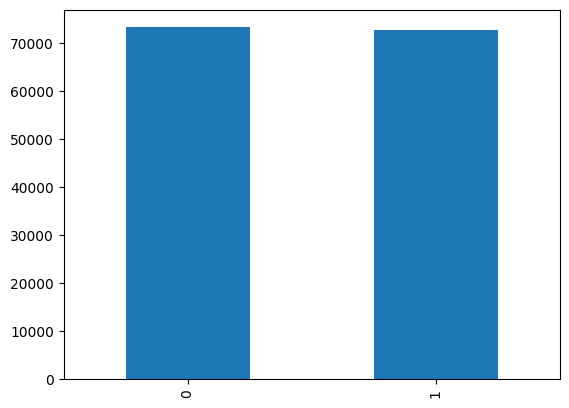

In [14]:
train_data['label'].value_counts().plot(kind = 'bar')

**pandas의 value_counts()함수**는 데이터분석하는데 있어 가장 기초적이면서 일반적으로 사용되는 함수이다.

기본적으로 지정된 열의 각 값value에 대한 모든 발생 횟수를 반환한다.

그래프 상으로 긍정과 부정 둘 다 약 72,000개의 샘플이 존재하여 레이블의 분포가 균일한 것처럼 보인다. 정확하게 몇 개인지 확인해보면

In [15]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


결과를 확인해보면 레이블이 0인 리뷰가 조금 더 많은 것을 확인할 수 있다.


이제 리뷰 중에 Null 값을 가진 샘플이 있는지 확인해보면,

In [16]:
print(train_data.isnull().values.any())

True


True가 나왔다면 데이터 중에 Null 값을 가진 샘플이 존재한다는 의미로,어떤 열에 존재하는지 확인해보면

In [17]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


결과를 확인해보면 document 열에서 Null 값을 가진 샘플이 총 1개가 존재하는것을 확인할 수 있다

NULL이 어느 인덱스의 위치에 존재하는지 한 번 출력해서 확인해보면,

In [18]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


Null 값이 존재하는 행 제거

In [19]:
train_data = train_data.dropna(how = 'any')  # dropna(how = 'any')는 인덱스방향(행)으로 한번씩 훑으면서 nan이 하나라도 있으면 해당 행을 삭제시키겠다는 의미
print(train_data.isnull().values.any())      # Null 값이 존재하는지 확인 (false로 Null 값을 가진 샘플이 제거되었음을 확인할 수 있다)

False


샘플 하나가 잘 제거되었는지 확인해보면

In [20]:
print(len(train_data))  #146183에서 146182로 하나 제거되었음을 확인할 수 있다

146182


# **정규 표현식**

pratice

In [21]:
#알파벳과 공백을 제외하고 모두 제거
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))    #sub는 문자열에 맞는 패턴을 2번째 인자(교체할 문자열)로 교체합니다.

do you expect people to read the FAQ etc and actually accept hard atheism


'[^a-zA-Z]':	''사이에 영문자가 없는 패턴으로 알파벳과 공백을 제외하고 모두 제거하여 출력

**위와 같은 원리를 한국어 데이터에 적용하기 위해**

**1.우선 자음과 모음에 대한 범위 지정**

**2. train_data에 한글과 공백을 제외하고 모두 제거하는 정규 표현식을 수행**

In [22]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

<ipython-input-22-4419b0600db1>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


 출력결과를 확인해보면 정규 표현식을 수행함으로 인해 기존의 띄어쓰기는 유지되면서 온점과 같은 구두점 등은 제거되었음을 확인할 수 있다

train_data에 공백(whitespace)만 있거나 빈 값을 가진 행이 있다면 Null 값으로 변경하도록 하고, Null 값이 존재하는지 확인해보겠다.

In [23]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

<ipython-input-23-c2f9538d5bc3>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


id            0
document    789
label         0
dtype: int64


Null 값이 789개가 생긴것을 확인할 수 있다

Null 샘플들은 레이블이 긍정일 수도 있고, 부정일 수도 있습니다. 아무런 의미도 없는 데이터므로 제거해주고 잘 제거되었는지 개수를 확인해보면

In [24]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


테스트 데이터에도 앞서 진행한 전처리 과정을 동일하게 진행한다.

In [25]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


<ipython-input-25-c182d8fa0991>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-25-c182d8fa0991>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


# **토큰화**

불용어란?

갖고 있는 데이터에서 유의미한 단어 토큰만을 선별하기 위해서는 큰 의미가 없는 단어 토큰을 제거하는 작업이 필요하다.

 (여기서 큰 의미가 없다는 것은 자주 등장하지만 분석을 하는 것에 있어서는 큰 도움이 되지 않는 단어) 이러한 단어들을 불용어(stopword)라고 한다

In [26]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [27]:
# 토큰화
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

Okt는 위와 같이 KoNLPy에서 제공하는 형태소 분석기이다.
한국어을 토큰화할 때는 영어처럼 띄어쓰기 기준으로 토큰화를 하는 것이 아니라, 주로 형태소 분석기를 사용한다
stem = True는 일정 수준의 정규화를 수행해주는데, 예를 들어 위의 예제의 결과를 보면 '이런'이 '이렇다'로 변환되었고 '만드는'이 '만들다'로 변환된 것을 알 수 있다


train_data에 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 X_train에 저장한다.

In [ ]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

 24%|██▍       | 34654/145393 [02:02<04:42, 391.82it/s]

In [ ]:
print(X_train[:3])              # 상위3개의 샘플만 출력해서 확인해보면 형태소 토큰화가 잘 진행되는것을 확인할 수있

In [ ]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

# **정수 인코딩**

컴퓨터는 텍스트보다는 숫자를 더 잘 처리 할 수 있다.

이를 위해 자연어 처리에서는 텍스트를 숫자로 바꾸는 여러가지 기법들이 있고, 이러한 기법들을 본격적으로 적용시키기 위한 첫 단계로 각 단어를 고유한 정수에 맵핑(mapping)시키는 전처리 작업이 필요할 때가 있다.

단어에 정수를 부여하는 방법 중 하나로 단어를 빈도수 순으로 정렬한 단어 집합(vocabulary)을 만들고, 빈도수가 높은 순서부터 차례로 낮은 정수를 부여하는 방법이 있다.



In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)       #  tokenizer.word_index를 출력하여 확인해보면 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었음을 확인할 수 있다

각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여되었기 때문에, 낮은 정수가 부여된 단어들은 빈도수가 높고, 높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미합니다.

등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보면

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장빈도가 3회미만인 단어들은 단어집합에서의 희귀 단어의 비율이 약55%로 절반 이상을 차지하지만 전채 등장빈도에서 희귀 단어 등장 빈도 비율은 1.87로 매우 적은 비율을 차지하는 것을 보아 자연어 처리에서 별로 중요하지 않ㄷ고 판단할 수 있는 결과가 나왔다

그래서 이 단어들은 정수 인코딩 과정에서 배제시킨 후,


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

이 단어 집합의 크기를 케라스 토크나이저의 인자로 넘겨주고 텍스트 시퀀스를 정수 시퀀스로 변환합니다.

In [ ]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

잘 진행되었는지 확인하기위해 상위3의 샘플을  추출해서 확인해보면 각 단어에 대한 정수로 변환된 것을 확인할 수 있습니다.

In [ ]:
print(X_train[:3])

 train_data에서 y_train과 y_test를 별도로 저장해줍니다 .


In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])


# **5) 빈 샘플(empty samples) 제거**

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 빈(empty) 샘플이 되었다는 것을 의미합니다.

이런 빈샘플에는 어떤 레이블이 붙어있어도 의미가 없으므로 제거해주는 작업을 해야한다

1. 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 받아온다
2. 빈샘플 제거
3. 빈 샘플을 제거한 후의 샘플의 개수 확인

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))     #결과확인 145162로 줄어든것 확인가능

# **패딩**

자연어 처리를 하다보면 각 문장(또는 문서)은 서로 길이가 다를 수 있습다

그런데 기계는 길이가 전부 동일한 문서들에 대해서는 하나의 행렬로 보고, 한꺼번에 묶어서 처리할 수 있기때문에 병렬 연산을 위해서 여러 문장의 길이를 임의로 동일하게 맞춰주는 작업이 필요할 때가 있다.

1. 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보면

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()                            # 리뷰의 최대길이는 69. 평균적으로 약 11내외의 길이를 가지는 것을 볼 수있다

모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있기에 특정 길이 변수를 max_len으로 정한다.

 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만든다.

 (그래프에소 MAX LEN=30이 적당할거같아) 이 값이 얼마나 많은 리뷰를 커버할 수있는지 확인해보면

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 30
below_threshold_len(max_len, X_train)         # 약 94%의 리뷰가 30이하의 길이를 가지는 것을 확인할수있다

따라서 모든 리뷰의 길이를 30으로 새팅

In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# **2. LSTM으로 네이버 영화 리뷰 감성 분류하기**

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

하이퍼파라미터인 임베딩 벡터의 차원은 100, 은닉 상태의 크기는 128입니다. 모델은 다 대 일 구조의 LSTM을 사용합니다. 해당 모델은 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델입니다. 이진 분류 문제의 경우, 출력층에 로지스틱 회귀를 사용해야 하므로 활성화 함수로는 시그모이드 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용합니다.

EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)는 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)한다는 의미입니다. ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다.

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

테스트 데이터에서 85.44%의 정확도를 얻습니다.

In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle)

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# **3. 리뷰 예측해보기**

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))